In [4]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *

## 0. Classification 
- With Two Hidden Layer and ReLu Activation Func
- Process
    - Initialize params / define hyperparams
    - Loop for num_iteration
        - Forward Propagation
        - Compute cost Func
        - Backward Propagation
        - Update params
    - Use trained params for prediction

### Code structure

In [ ]:
def initialize_params(Num of feature, Num of Unit of Layer, Num of output data):
    ...pass
    return params

def linear_activation_forward(A of previous layer, W, b, activation func):
    ...pass
    return A, cache

def comput_cost(AL, Y):
    ...pass
    return cost

def linear_activation_backward(dA, cache, activation func):
    ...pass
    return dA of previous layer

def update_params(params, grads, learning_rate):
    ...pass
    return params

## 1. Dataset

In [6]:
train_X_orig, train_y, test_X_orig, test_y, classes = load_data()

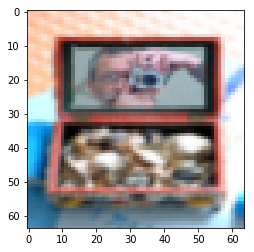

In [11]:
idx = 15
plt.imshow(train_X_orig[idx])

In [21]:
train_sample = train_X_orig.shape[0]
num_px = train_X_orig.shape[1:]
test_sample = test_X_orig.shape[0]

print("Num of train sample: {}".format(train_sample))
print("Num of test sample: {}".format(test_sample))
print("image size: {}".format(num_px))

Num of train sample: 209
Num of test sample: 50
image size: (64, 64, 3)


In [38]:
n_x = np.product(num_px); n_h = 7; n_y = 1
layer_dims = (n_x, n_h, n_y)

## 2. Preprocessing

In [29]:
train_x_flatten = train_X_orig.reshape(train_X_orig.shape[0], -1).T
test_X_flatten = test_X_orig.reshape(test_X_orig.shape[0], -1)

train_X = train_x_flatten / 255
test_X = test_X_flatten / 255
train_X.shape

(12288, 209)

## 3. Build two layer Model

In [119]:
#############################################

def sigmoid(Z):
    return 1 / 1 + np.exp(-Z), Z

#############################################

def relu(Z):
    assert(np.maximum(0, Z).shape == Z.shape) 
    return np.maximum(0, Z), Z

#############################################

def initialize_parameters(n_x, n_h, n_y):
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))

    params = {'W1': W1,
         'b1': b1,
         'W2': W2,
         'b2': b2}
    
    return params

#############################################

def compute_cost(AL, Y):
    m = Y.shape[1]
    loss = - np.dot(Y, np.log(AL).T) - np.dot(1 - Y, np.log(1 - AL).T)
    print(np.dot(1 - Y, np.log(1 - AL).T))
    cost = (1./m) * (loss)
    cost = np.squeeze(cost)
    
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    print(cost)
    assert (cost.shape == ())
    return cost

#############################################

def linear_activation_forward(A, W, b):
    
    Z = W.dot(A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache

#############################################

def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    elif activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    
    return A, cache


#############################################

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    return dZ

#############################################

def sigmoid_backward(dA, cache):
    Z = cache
    
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert(dZ.shape == Z.shape)
    return dZ

#############################################

def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1./m * np.dot(dZ, A_prev.T)
    db = 1./m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

#############################################

def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db
    
#############################################

def update_params(params, grads, learning_rate):
    L = len(params) // 2
    
    for l in range(1, L+1):
        
        params["W" + str(l)] = params["W" + str(l)] \
        - learning_rate * grads["dW" + str(l)]
        
        params["b" + str(l)] = params["b" + str(l)] \
        - learning_rate * grads["db" + str(l)]
    
    return params

#############################################




In [109]:
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iteration=3000, print_cost=False):
    
    # init
    np.random.seed(1)
    
    costs = []
    grads = {}
    m = X.shape[1]
    
    (n_x, n_h, n_y) = layers_dims
    params = initialize_parameters(n_x, n_h, n_y)
    
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    
    # Loop
    for i in range(0, num_iteration):
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        cost = compute_cost(A2, Y)
        # init
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')

        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # updated params
        params = update_params(params, grads, learning_rate)
        W1 = params['W1']
        b1 = params['b1']
        W2 = params['W2']
        b2 = params['b2']
        
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)
        
    plt.plit(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iteration (per tens)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    
    return params

In [120]:
two_layer_model(train_X, train_y, layers_dims = (n_x, n_h, n_y), num_iteration = 2500, print_cost=True)

[[nan]]
[[nan]]


AssertionError: 

질문
- compute cost 작동 안함